# Revised Universal Soil Loss Equation 🪐

La RUSLE (Revised Universal Soil Loss Equation) mide:

Erosión del suelo por el agua: Específicamente, calcula la cantidad promedio anual de suelo perdido por erosión hídrica superficial en un área determinada. Esta cantidad se expresa generalmente en toneladas por hectárea por año.

R (Factor de erosividad de la lluvia):
Descripción: Refleja la energía y cantidad de lluvia, relacionada con la erosión del suelo por el impacto directo de las gotas de lluvia y el escurrimiento superficial.
Unidades: MJ mm/(ha·h·año)

K (Factor de erodabilidad del suelo):
Descripción: Representa la susceptibilidad del suelo a la erosión, teniendo en cuenta factores como textura, materia orgánica, estructura, y permeabilidad.
Unidades: ton·h/MJ·mm

LS (Factor topográfico):
Descripción: Combina la influencia de la longitud y la inclinación de la pendiente en la erosión del suelo. Esencialmente, cómo la topografía afecta la velocidad y cantidad de escurrimiento superficial.
Unidades: Adimensional

C (Factor de manejo del cultivo):
Descripción: Refleja el efecto de las prácticas agrícolas en la erosión, incluyendo el tipo de cultivo, rotación y residuos en el suelo.
Unidades: Adimensional

P (Factor de prácticas de conservación):
Descripción: Denota la efectividad de prácticas específicas de conservación en reducir la erosión, como terrazas, franjas de cultivo y barreras.
Unidades: Adimensional

Llamado a las librerías

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
!pip install rasterio
import numpy as np
from google.colab import files
import folium
import time
from tqdm import tqdm

import rasterio
from rasterio.mask import mask
from rasterio.transform import from_origin
from rasterio.warp import reproject, Resampling
from rasterio.enums import Resampling
from rasterio.plot import show as rshow
import os



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 34.1 MB/s eta 0:00:00


Exploración de la Zona de Estudio

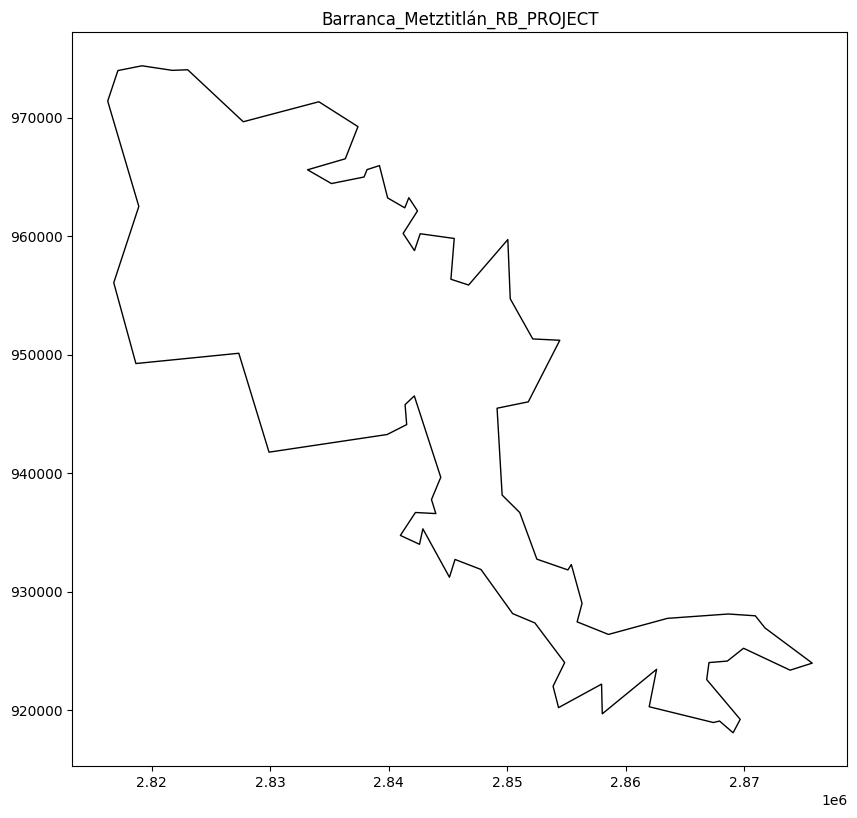

<Projected CRS: PROJCS["ITRF_1992_Lambert_Conformal_Conic",GEOGCS[ ...>
Name: ITRF_1992_Lambert_Conformal_Conic
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: International Terrestrial Reference Frame 1992
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
# Cargar el shapefile
gdf = gpd.read_file("/content/drive/MyDrive/Planeación del uso de los RN/Prácticas/CAPAS_SIG/Capas/Barranca_Metztitl n_RB_PROJECT.shp")

# Verificar la proyección
crs = gdf.crs

# Visualizar el shapefile
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, edgecolor="k", facecolor="none")
ax.set_title("Barranca_Metztitlán_RB_PROJECT")
plt.show()

crs

# Factor R 🌧

In [ ]:
#!pip install earthengine-api
#!pip install geemap

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=ar2pYf1EzD47kFI2mwsC6LRinOk03CRW4soiVtOfGsg&tc=MIcdp0L2CcHpStSCjdPJ5Dpie2amSTZTMRdMlfoOH9Q&cc=VwVS2E_wfW_snY1Iq3CEjvcT0FmpyjqA4wXPbuB4KQw

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXnL4cVe6eeyKxu8P5rAjSNTEBcEX0p9Xe4OBJvf5d7K_dOP29kzbVY

Successfully saved authorization token.


Extracción de datos de lluvia de GEE

In [ ]:
"""
The climate hazards infrared precipitation with stations—a new environmental record for monitoring extremes

"""

In [ ]:
ee.Initialize()
def generar_mapa_precipitacion(estado):
    # Definir el conjunto de datos y filtrar por fecha
    dataset = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD').filter(ee.Filter.date('1980-01-01', '2010-01-01'))

    # Convertir los datos pentadales en datos anuales sumando todas las pentadas en un año
    precipitacion_anual = dataset.sum()

    # Calcular la precipitación media anual para el período 2000-2023
    precipitacion_media_anual = precipitacion_anual.divide(30)

    # Obtener el límite del estado especificado en México
    limite_estado = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM1_NAME', estado))

    # Recortar los datos de precipitación media anual al estado especificado
    precipitacion_media_anual_estado = precipitacion_media_anual.clip(limite_estado)

    # Definir los parámetros de visualización
    parametros_vis = {
        'min': 0,
        'max': 2000,  # Ajusta este valor según los valores esperados de precipitación anual
        'palette': ['001137', '0aab1e', 'e7eb05', 'ff4a2d', 'e90000']
    }

    # Crear un mapa folium centrado en el estado especificado
    centro_estado = limite_estado.geometry().centroid().getInfo()['coordinates']
    mapa = folium.Map(location=[centro_estado[1], centro_estado[0]], zoom_start=8)

    # Función para agregar conjuntos de datos de Earth Engine a un mapa folium
    def agregar_capa_ee(self, objeto_imagen_ee, params_vis, nombre):
        map_id_dict = ee.Image(objeto_imagen_ee).getMapId(params_vis)
        folium.raster_layers.TileLayer(
            tiles=map_id_dict['tile_fetcher'].url_format,
            attr='Datos del mapa &copy; Google Earth Engine',
            name=nombre,
            overlay=True,
            control=True
        ).add_to(self)

    # Agregar el método de dibujo de Earth Engine a folium
    folium.Map.add_ee_layer = agregar_capa_ee

    # Agregar la capa de Earth Engine al mapa folium
    mapa.add_ee_layer(precipitacion_media_anual_estado, parametros_vis, 'Precipitación Media Anual (1980-2010) - ' + estado)

    # Agregar un panel de control de capas al mapa
    mapa.add_child(folium.LayerControl())

    # Calcular los valores mínimos y máximos de la capa de precipitación media anual para el estado
    valores_min_max = precipitacion_media_anual_estado.reduceRegion(
        reducer=ee.Reducer.minMax(),
        geometry=limite_estado.geometry(),
        scale=5000,  # escala en metros
        maxPixels=1e9
    )

    valor_min = valores_min_max.get('precipitation_min').getInfo()
    valor_max = valores_min_max.get('precipitation_max').getInfo()

    print("Valor mínimo de precipitación media anual:", valor_min)
    print("Valor máximo de precipitación media anual:", valor_max)

    # Especificar los parámetros de exportación
    parametros_exportacion = {
        'image': precipitacion_media_anual_estado,
        'description': 'PrecipitacionMediaAnual_' + estado,
        'folder': 'CAPAS_SIG',  # Opcional. Especifica el nombre de la carpeta en tu Google Drive donde deseas guardar la imagen
        'scale': 5000,  # Escala en metros
        'region': limite_estado.geometry(),
        'maxPixels': 1e9,
        'fileFormat': 'GeoTIFF'  # Puedes elegir otros formatos como 'TFRecord'
    }

    # Iniciar el proceso de exportación a Google Drive
    tarea = ee.batch.Export.image.toDrive(**parametros_exportacion)
    tarea.start()

    # Informar al usuario que el proceso de exportación ha comenzado
    print(f"La exportación de la precipitación media anual para {estado} ha comenzado.")

    # Monitorear la tarea de exportación
    while tarea.active():
        print('Tarea de exportación en progreso...')
        # Espera unos segundos antes de verificar nuevamente
        time.sleep(30)

    # Verificar el estado de la tarea después de que haya dejado de estar activa
    estado = tarea.status()
    if estado['state'] == 'COMPLETED':
        print('Tarea completada exitosamente.')
    elif estado['state'] == 'FAILED':
        print('Error en la tarea:', estado['error_message'])
    else:
        print('Tarea', estado['state'])
    # Mostrar el mapa
    return mapa



In [ ]:
mapa_hidalgo = generar_mapa_precipitacion('Hidalgo')
mapa_hidalgo

Valor mínimo de precipitación media anual: 172.8434644382447
Valor máximo de precipitación media anual: 2217.97428030173
La exportación de la precipitación media anual para Hidalgo ha comenzado.
Tarea de exportación en progreso...
Tarea completada exitosamente.


In [ ]:

def calculate_R(region, precipitation_raster_path):
    """
    Calcula el factor R basado en la región y el ráster de precipitación.

    Parámetros:
    - region: Un entero que representa la región (del 1 al 14).
    - precipitation_raster_path: Ruta al archivo ráster con la precipitación media anual.

    Devoluciones:
    - R_factor_raster: Un arreglo numpy con el factor R calculado.
    """

    if region not in range(1, 15):
        raise ValueError("La región debe estar entre 1 y 14.")

    # Abrir el raster
    with rasterio.open(precipitation_raster_path) as src:
        precipitation_data = src.read(1)

    # Ecuaciones por región
    equations = {
        1: lambda P: 1.2078*P + 0.002276*P**2,
        2: lambda P: 3.4555*P + 0.006470*P**2,
        3: lambda P: 3.6752*P - 0.001720*P**2,
        4: lambda P: 2.8959*P + 0.002983*P**2,
        5: lambda P: 3.4880*P - 0.000188*P**2,
        6: lambda P: 6.6847*P + 0.001680*P**2,
        7: lambda P: (-0.0334)*P + 0.0061*P**2,
        8: lambda P: 1.9967*P + 0.003270*P**2,
        9: lambda P: 7.0458*P - 0.002096*P**2,
        10: lambda P: 6.8938*P + 0.000442*P**2,
        11: lambda P: 3.7745*P + 0.004540*P**2,
        12: lambda P: 2.4619*P + 0.006067*P**2,
        13: lambda P: 10.7427*P - 0.001008*P**2,
        14: lambda P: 1.5005*P + 0.002640*P**2
    }

    # Calcular R
    R_factor_raster = equations[region](precipitation_data)

    # Visualizar el raster
    plt.figure(figsize=(10, 10))
    plt.imshow(R_factor_raster, cmap='viridis')  # 'viridis' es solo una paleta de colores, puedes usar otra si prefieres
    plt.colorbar(label='Factor R')
    plt.title('Factor R basado en precipitación')
    plt.show()

    return R_factor_raster

# Placeholder to test the function (we will test it after you provide the raster data)
"Función definida con éxito."


'Función definida con éxito.'

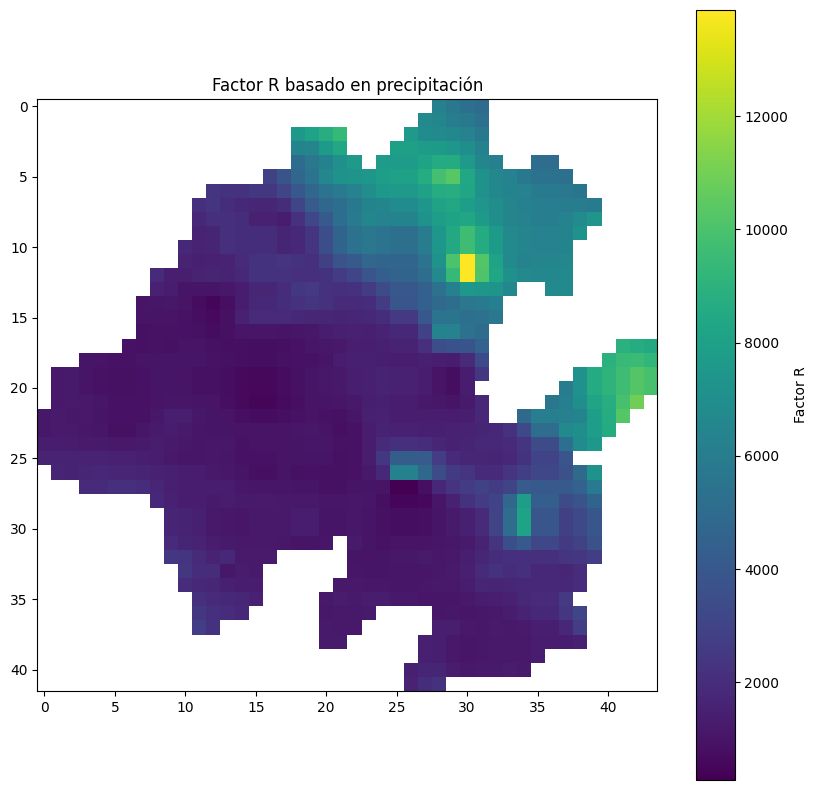

In [ ]:
# Definir la ruta del ráster y la región
path_to_raster = "/content/drive/MyDrive/Planeación del uso de los RN/Prácticas/CAPAS_SIG/PrecipitacionMediaAnual_Hidalgo.tif"
selected_region = 1  # Por ejemplo, para la región 5

# Llamar a la función
resulting_R_factor = calculate_R(selected_region, path_to_raster)


# Factor LS ⛰

In [ ]:
import ee
import folium

# Inicializar Google Earth Engine
ee.Initialize()

# Definir la geometría de Hidalgo
hidalgo_geometry = ee.Geometry.Polygon(
        [[[-99.7, 20.0],
          [-99.7, 21.5],
          [-98.2, 21.5],
          [-98.2, 20.0]]])

# Cargar el DEM de Copernicus
dem = ee.ImageCollection("COPERNICUS/DEM/GLO30").mosaic().select('DEM')  # Seleccionamos la banda 'elevation'

# Recortar el DEM usando la geometría de Hidalgo
dem_hidalgo = dem.clip(hidalgo_geometry)

# Define los parámetros de visualización para el DEM.
vis_params = {
    "min": 0,
    "max": 3000,
    "palette": ["white", "blue", "green", "yellow", "red"]
}

# Define una función para visualizar las capas de datos de Earth Engine usando folium.
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Añade el método de dibujo de Earth Engine a folium.
folium.Map.add_ee_layer = add_ee_layer

# Crea un objeto de mapa folium.
m = folium.Map(location=[20.8, -98.9], zoom_start=9)

# Añade la capa DEM al mapa.
m.add_ee_layer(dem_hidalgo, vis_params, 'DEM Hidalgo')

# Añade un panel de control de capa al mapa.
m.add_child(folium.LayerControl())

# Código para mostrar el mapa.
m


In [ ]:
import time
import ee
import folium

# Inicializar Google Earth Engine
ee.Initialize()

def generar_mapa_dem(estado):
    # Cargar el DEM de Copernicus
    dem = ee.ImageCollection("COPERNICUS/DEM/GLO30").mosaic().select('DEM')

    # Obtener el límite del estado especificado en México
    limite_estado = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM1_NAME', estado))

    # Recortar el DEM al estado especificado
    dem_estado = dem.clip(limite_estado)

    # Definir los parámetros de visualización
    parametros_vis = {
        'min': 0,
        'max': 3000,  # Puedes ajustar estos valores según el rango esperado de elevaciones en tu área de interés
        'palette': ["white", "blue", "green", "yellow", "red"]
    }

    # Crear un mapa folium centrado en el estado especificado
    centro_estado = limite_estado.geometry().centroid().getInfo()['coordinates']
    mapa = folium.Map(location=[centro_estado[1], centro_estado[0]], zoom_start=8)

    # Función para agregar conjuntos de datos de Earth Engine a un mapa folium
    def agregar_capa_ee(self, objeto_imagen_ee, params_vis, nombre):
        map_id_dict = ee.Image(objeto_imagen_ee).getMapId(params_vis)
        folium.raster_layers.TileLayer(
            tiles=map_id_dict['tile_fetcher'].url_format,
            attr='Datos del mapa &copy; Google Earth Engine',
            name=nombre,
            overlay=True,
            control=True
        ).add_to(self)

    # Agregar el método de dibujo de Earth Engine a folium
    folium.Map.add_ee_layer = agregar_capa_ee

    # Agregar la capa de Earth Engine al mapa folium
    mapa.add_ee_layer(dem_estado, parametros_vis, 'DEM - ' + estado)

    # Agregar un panel de control de capas al mapa
    mapa.add_child(folium.LayerControl())

    # Especificar los parámetros de exportación
    parametros_exportacion = {
        'image': dem_estado,
        'description': 'DEM_' + estado,
        'folder': 'Capas',
        'scale': 30,
        'region': limite_estado.geometry(),
        'maxPixels': 1e9,
        'fileFormat': 'GeoTIFF'
    }

    # Iniciar el proceso de exportación a Google Drive
    tarea = ee.batch.Export.image.toDrive(**parametros_exportacion)
    tarea.start()

    # Informar al usuario que el proceso de exportación ha comenzado
    print(f"La exportación del DEM para {estado} ha comenzado.")

    # Monitorear la tarea de exportación
    while tarea.active():
        print('Tarea de exportación en progreso...')
        time.sleep(30)

    # Verificar el estado de la tarea después de que haya dejado de estar activa
    estado_tarea = tarea.status()
    if estado_tarea['state'] == 'COMPLETED':
        print('Tarea completada exitosamente.')
    elif estado_tarea['state'] == 'FAILED':
        print('Error en la tarea:', estado_tarea['error_message'])
    else:
        print('Tarea', estado_tarea['state'])

    # Mostrar el mapa
    return mapa


In [ ]:
# Uso de la función (puede tomar varios minutos)
mapa_dem = generar_mapa_dem("Hidalgo")
mapa_dem

La exportación del DEM para Hidalgo ha comenzado.
Tarea de exportación en progreso...
Tarea de exportación en progreso...
Tarea de exportación en progreso...
Tarea de exportación en progreso...
Tarea de exportación en progreso...
Tarea de exportación en progreso...
Tarea de exportación en progreso...
Tarea de exportación en progreso...
Tarea de exportación en progreso...
Tarea completada exitosamente.


# Factor K 💎

In [ ]:
def calcular_valores_fac_k(ruta_shapefile):
    # Leer el shapefile
    suelo_gdf = gpd.read_file(ruta_shapefile)

    # Mapear valores de la columna TEXTURA
    mapeo_textura = {
        "Fina": "F",
        "Media": "M"  # Cualquier otro valor se asume como "G"
    }
    suelo_gdf['TEXTURA_MAPEADA'] = suelo_gdf['TEXTURA'].map(lambda x: mapeo_textura.get(x, "G"))

    # Diccionario con los valores de suelo-textura
    valores_suelo = {
            "AC": {"G": 0.026, "M": 0.04, "F": 0.013},
    "AL": {"G": 0.026, "M": 0.04, "F": 0.013},
    "AN": {"G": 0.026, "M": 0.04, "F": 0.013},
    "AR": {"G": 0.013, "M": 0.02, "F": 0.007},
    "CH": {"G": 0.013, "M": 0.02, "F": 0.007},
    "CL": {"G": 0.053, "M": 0.079, "F": 0.026},
    "CM": {"G": 0.026, "M": 0.04, "F": 0.013},
    "DU": {"G": 0.053, "M": 0.079, "F": 0.026},
    "FL": {"G": 0.026, "M": 0.04, "F": 0.013},
    "FR": {"G": 0.013, "M": 0.02, "F": 0.007},
    "GL": {"G": 0.026, "M": 0.04, "F": 0.013},
    "GY": {"G": 0.053, "M": 0.079, "F": 0.026},
    "HS": {"G": 0.053, "M": 0.02, "F": 0.007},
    "KS": {"G": 0.026, "M": 0.04, "F": 0.013},
    "LP": {"G": 0.013, "M": 0.02, "F": 0.007},
    "LV": {"G": 0.026, "M": 0.04, "F": 0.013},
    "LX": {"G": 0.013, "M": 0.02, "F": 0.007},
    "NT": {"G": 0.013, "M": 0.02, "F": 0.007},
    "PH": {"G": 0.013, "M": 0.02, "F": 0.007},
    "PL": {"G": 0.053, "M": 0.079, "F": 0.026},
    "PT": {"G": 0.026, "M": 0.04, "F": 0.013},
    "RG": {"G": 0.026, "M": 0.04, "F": 0.013},
    "SC": {"G": 0.026, "M": 0.04, "F": 0.013},
    "SN": {"G": 0.053, "M": 0.079, "F": 0.026},
    "UM": {"G": 0.026, "M": 0.04, "F": 0.013},
    "VR": {"G": 0.053, "M": 0.079, "F": 0.026}
}

    # Función para obtener el valor basado en el tipo y textura del suelo
    def obtener_valor(suelo, textura):
        if suelo in valores_suelo and textura in valores_suelo[suelo]:
            return valores_suelo[suelo][textura]
        else:
            return None

    # Calcular valores para la columna 'Fac_K'
    suelo_gdf['Fac_K'] = suelo_gdf.apply(lambda fila: obtener_valor(fila['GRUPO1'], fila['TEXTURA_MAPEADA']), axis=1)

    # Guardar el GeoDataFrame actualizado en un nuevo shapefile
    ruta_salida = ruta_shapefile.replace(".shp", "_actualizado.shp")
    suelo_gdf.to_file(ruta_salida)

        # Desplegar el resultado en un mapa
    fig, ax = plt.subplots(figsize=(15, 15))
    suelo_gdf.plot(column='Fac_K', cmap='YlGnBu', legend=True, ax=ax)
    ax.set_title("Mapa del suelo con valores 'Fac_K'")
    plt.show()

    print(f"Shapefile actualizado guardado en: {ruta_salida}")

<ipython-input-43-0a04196e05e9>:54: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  suelo_gdf.to_file(ruta_salida)


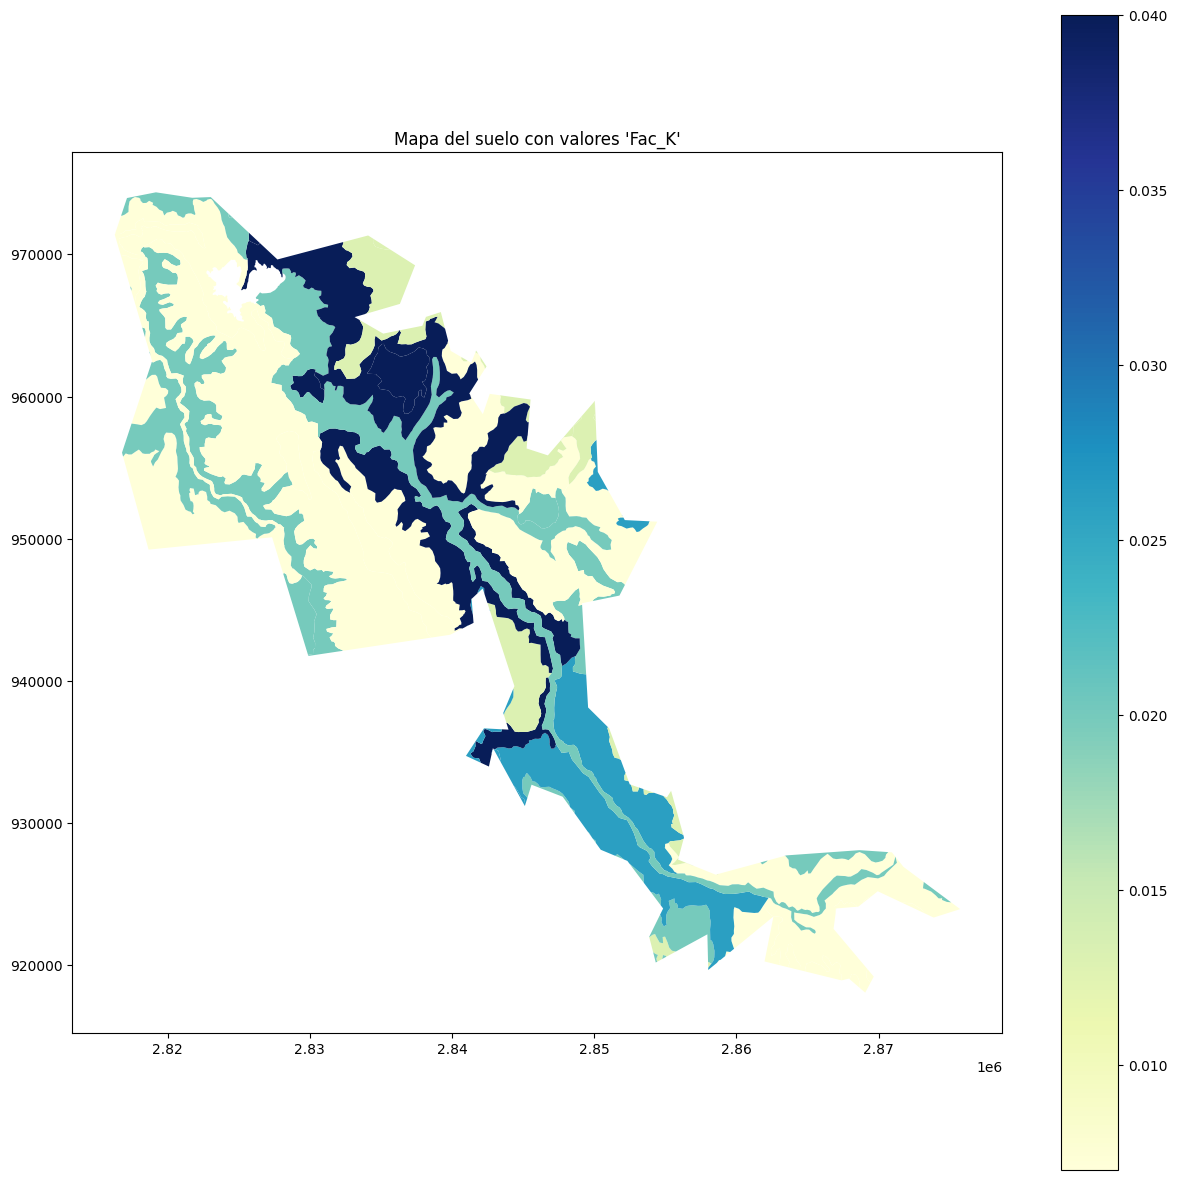

Shapefile actualizado guardado en: /content/drive/MyDrive/Planeación del uso de los RN/Prácticas/CAPAS_SIG/Capas/EDA_METZ_250000_actualizado.shp


In [ ]:
#Calcular K
ruta_shp = "/content/drive/MyDrive/Planeación del uso de los RN/Prácticas/CAPAS_SIG/Capas/EDA_METZ_250000.shp"  # Introduce aquí la ruta de tu shapefile
calcular_valores_fac_k(ruta_shp)

# Factor C 🌱

# Factor P 👷

# Tasa de Erosión Anual ❎

In [ ]:
# Ejemplo de uso:
shapefile_path = "/content/drive/MyDrive/Planeación del uso de los RN/Prácticas/CAPAS_SIG/Capas/Barranca_Metztitl n_RB_PROJECT.shp"
carpeta_destino = "/content/drive/MyDrive/Planeación del uso de los RN/Prácticas/CAPAS_SIG/Capas"
resolucion_pixel = 30
rasters = ["/content/drive/MyDrive/Planeación del uso de los RN/Prácticas/CAPAS_SIG/Capas/PrecipitacionMediaAnual_Hidalgo.tif"]
procesar_rasters(shapefile_path, carpeta_destino, resolucion_pixel, rasters)

NameError: ignored

In [ ]:
def show_raster_info(file_path):
    # Abre el ráster
    with rasterio.open(file_path) as src:
        # Muestra el ráster
        fig, ax = plt.subplots(figsize=(10, 6))
        rshow(src, ax=ax)
        plt.show()

        # Muestra la información de proyección y datum
        print("Proyección:\n", src.crs.wkt)

        # Si el CRS tiene un datum
        if src.crs.datum:
            print("\nDatum:\n", src.crs.datum)
        else:
            print("\nEl CRS no especifica un datum explícitamente.")


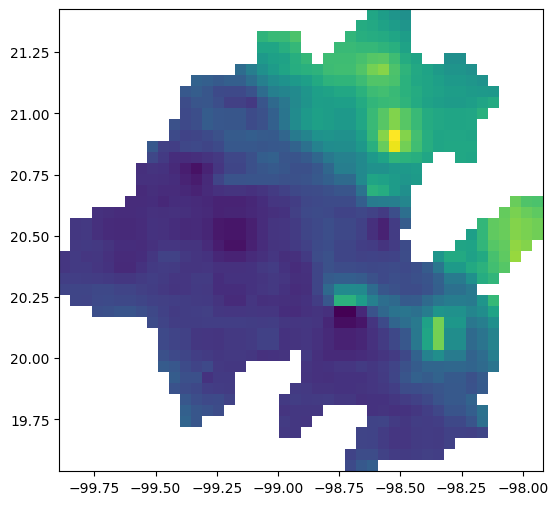

Proyección:
 GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


AttributeError: ignored

In [ ]:

# Especifica la ruta del archivo ráster aquí:
file_path = "/content/drive/MyDrive/Planeación del uso de los RN/Prácticas/CAPAS_SIG/Capas/PrecipitacionMediaAnual_Hidalgo.tif"
show_raster_info(file_path)